# Preprocesado de las noticias

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Nicer style
style.use('seaborn') 

Pre-procesado para eliminar URLS, símbolos. Es decir, cosas que no son palabras

In [2]:
import re #regexp

Tokenizer de NLTK (Natural Language Tool Kit) basado en expresiones regulares.

In [3]:
from nltk.tokenize import RegexpTokenizer

### Limpieza del dataset
Cargamos el dataset de noticias

In [18]:
news = pd.read_csv("../../data/news_cleaned_2018_02_13.csv", nrows=30_000)

news = news[['type', 'content', 'title']]

#Remove columns with NaNs 
news = news.dropna()

In [19]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    #tokens = word_tokenize(text)
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]
    
    # filter out stop words
    #stop_words = set(stopwords.words('english'))
    #words = [w for w in words if not w in stop_words]
    
    return words

Limpiamos los campos que usaremos: Título y contenido

In [20]:
#Clean content
news['content'] = news.apply(lambda row: clean_text(row['content']), axis=1)
#Clean title
news['title'] = news.apply(lambda row: clean_text(row['title']), axis=1)

In [21]:
news.head(3)

,type,content,title
0,rumor,"[Life, is, an, illusion, at, least, on, a, qua...","[Is, life, an, ILLUSION, Researchers, prove, d..."
1,hate,"[Unfortunately, he, hasn, yet, attacked, her, ...","[Donald, Trump]"
2,hate,"[The, Los, Angeles, Police, Department, has, b...","[Donald, Trump]"


Las noticias están organizadas en las siguientes categorías

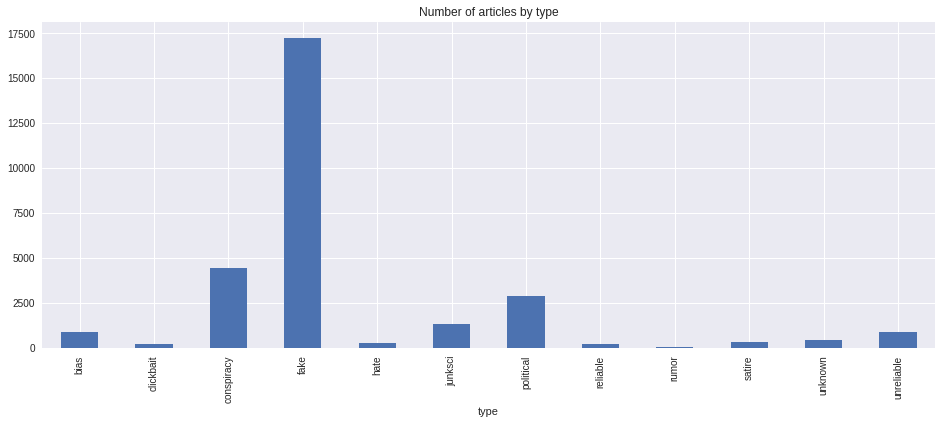

In [22]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

De aquí, y en base a las descripciones de [OpenSources](http://www.opensources.co) (de donde se han sacado las etiquetas del dataset) podemos agrupar varias categorías. Por ejemplo:
   * **Fake**
       * conspiracy
       * junksci
       * rumor
       * unknown
       * satire
       * hate
       * bias
   * **Truth**
       * reliable
       * political
   * **Clickbait**
       * clickbait

Convertimos los grupos en los nuevos.

In [23]:
def convert_tag(tag):
    """Convierte un tag a uno de tres grupos (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'bias'])
    truth = set(['reliable', 'political'])
    click = set(['clickbait'])
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    if tag in click:
        new_tag = 'click'
    return new_tag

In [24]:
news['type'] = news.apply(lambda row: convert_tag(row['type']), axis=1)

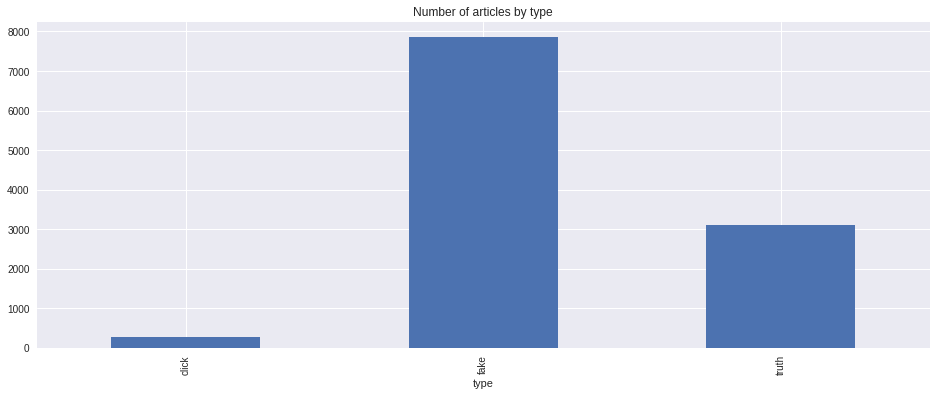

In [25]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

### Word2Vec

In [13]:
from gensim.models import KeyedVectors

Cargamos los vectores de un modelo entrenado por Google con los textos de millones de noticias

In [14]:
model = KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin.gz", binary=True)

Un ejemplo de predicción de palabras similares a "Trump"

In [26]:
model.most_similar("Trump")

MemoryError: 

A continuación convertimos las palabras del título y contenido de las noticias en vectores para poder pasárselos a una red neuronal.

In [ ]:
news['title_embeddings'] = news.apply(lambda r: 
                        np.array([model[x] for x in r['title'] if x in model.vocab]), axis=1)
news['content_embeddings'] = news.apply(lambda r: 
                        np.array([model[x] for x in r['content'] if x in model.vocab]), axis=1)

Un ejemplo de un artículo convertido a una matriz $M$ de dimensiones $l x 300$, donde $l$ es la longitud en palabras del artículo

In [ ]:
news['content_embeddings'][0]

In [ ]:
news['content_embeddings'][0].shape

Pero hay un **problema**: La entrada de la red no puede ser variable. Para solucionar esto, es necesario añadir padding a todas las matrices, de tal manera que todas tengan una longitud física.

Si miden menos de una cierta longitud $n$ ($l < n$) entonces se le añadirán "filas" con ceros hasta alacanzar las dimensiones necesarias. Si mide más, se truncará de tal manera que $l = n$

In [ ]:
def pad_matrix(matrix, token_len):
    """
    Funcion para añadir padding a una matriz hasta que tenga el número de filas 
    necesario.
    
    :param: token_len (int) longitud deseada en filas de la matriz
    :return: matriz con las dimensiones necesarias. 
    """
    tensor_token, depth = matrix.shape
    diff_token = token_len - tensor_token
    if(diff_token < 0):
        matrix = matrix[:token_len,:] #Select only part
    else:
        #Pad
        matrix = np.pad(matrix, ((0,diff_token),(0,0)), mode='constant', constant_values=0)
        
    return matrix

Es necesario encontrar un `token_len` que sea suficiente para que cubra, en general, la longitud de todos los artículos.

In [ ]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [ ]:
print("Número medio de tokens por artículo: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por artículo: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por artículo: {}".format(int(np.median(tokens_numbers))))

Escogemos el número máximo como $mean + 2\sigma$

In [ ]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

In [ ]:
n_tokens = max_tokens

In [ ]:
news['embeddings'] = news.apply(lambda r: pad_matrix(r['embeddings'], n_tokens) , axis=1)

Lo mismo para los títulos

In [ ]:
news['embeddings'][0].shape

### Convertir variable objetivo a OneHot Encodding

In [ ]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [ ]:
news.head()

Guardamos el dataset procesado como `.pickle` (serializado de objetos python).

In [ ]:
news.to_pickle("../../data/news_processed.pickle")